### Example 3, part A: Diffusion 

In this example we will look at the diffusion equation and how to handle second-order derivatives. For this, we will introduce Devito's `.laplace` short-hand expression and demonstrate it using the examples from step 7 of the original tutorial.

So, the equation we are now trying to implement is

$$\frac{\partial u}{\partial t} = \nu \frac{\partial ^2 u}{\partial x^2} + \nu \frac{\partial ^2 u}{\partial y^2}$$

To discretize this equation we will use central differences and reorganizing the terms yields

\begin{align}
u_{i,j}^{n+1} = u_{i,j}^n &+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n) \\
&+ \frac{\nu \Delta t}{\Delta y^2}(u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n)
\end{align}

As usual, we establish our baseline experiment by re-creating some of the original example runs. So let's start by defining some parameters.

Main problems were 

the extent parameter in grid
the datatype in grid 
and setting 'safe-math' = 1
setting to optimizations to 'noop'

In [156]:
#NBVAL_IGNORE_OUTPUT
from devito import Grid, TimeFunction, Eq, solve, configuration, Operator, Constant, Eq, solve, mmax
from sympy.abc import a
from sympy import simplify, sin
import numpy as np
import time
from math import pi, exp

configuration['safe-math'] = 1

# Some variable declarations
Nx = 4000
Ny = 4000
T = 1.0
nt = 1000
dt = 0.001
nu = 0.1

dx = 1.0;
dy = 1.0;
Lx = dx*(Nx-1);
Ly = dy*(Ny-1);

# Initialize `u` for space order 2
grid = Grid(shape=(Nx, Ny), extent=(Lx, Ly), dtype = np.float64)
u = TimeFunction(name='u', grid=grid, space_order=2)

3999.0


In [157]:
x, y = grid.dimensions

init_eq = Eq(u, 5*sin(pi*(x)/Lx)*sin(pi*(y)/Ly), subdomain=grid.interior)
init_eq
init_op = Operator(init_eq, opt='noop')
init_op(time=1)
#print(u.data[0])

Operator `Kernel` ran in 0.27 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.264503, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [158]:
# Create an operator with second-order derivatives
a = Constant(name='a')
eq = Eq(u.dt, a * u.laplace, subdomain=grid.interior)
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

# Create boundary condition expressions
x, y = grid.dimensions
t = grid.stepping_dim

bc = [Eq(u[t+1, 0, y], 0.)]  # left
bc += [Eq(u[t+1, Nx-1, y], 0.)]  # right
bc += [Eq(u[t+1, x, Ny-1], 0.)]  # top
bc += [Eq(u[t+1, x, 0], 0.)]  # bottom

op = Operator([eq_stencil]+bc, opt=('advanced', {'openmp': False}))

start_time = time.time() 

op(time=nt, dt=dt, a=nu)

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Runtime: {elapsed_time} seconds")

Operator `Kernel` ran in 21.17 s


Runtime: 21.179341077804565 seconds


In [159]:
#x, y = grid.dimensions
u_analytical = TimeFunction(name='u_analytical', grid=grid, space_order=2, dtype=np.float64)
error_field = TimeFunction(name='error_field', grid=grid, space_order=2, dtype=np.float64)
#max_error = TimeFunction(name='max_error', shape=(1,1), dimensions={1}, dtype=np.float64)
u_analytical = 5*exp(-nu*pi*pi*(1/Lx/Lx+1/Ly/Ly)*nt*dt)*sin(pi/Lx*x)*sin(pi/Ly*y)
#analytical_eq
#analytical_op = Operator(analytical_eq, opt='noop')

error_eq = Eq(error_field, abs((u_analytical-u)/u_analytical), subdomain=grid.interior)


check_op = Operator(error_eq, opt='noop')
check_op(time=1)
#print(error_field.data[0])
mmax(error_field)

Operator `Kernel` ran in 0.49 s


1.2354684632687516e-10

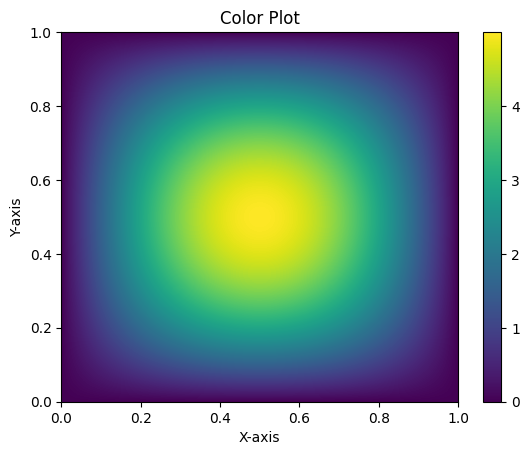

In [148]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, u.data[0].shape[0])
y = np.linspace(0, 1, u.data[0].shape[1])
X, Y = np.meshgrid(x, y)


plt.pcolormesh(X, Y, u.data[0], shading='auto')
plt.colorbar()  # Add a colorbar for reference
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Color Plot')
plt.show()

# print ("After", nt, "timesteps")
#plot_field(u.data[0], zmax=4.5)

In [128]:
def diffuse(u, nt):
    #un = np.zeros((Nx, Ny))
    for n in range(nt): 
        #un = u.copy()
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        nu * dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        nu * dt / dx**2 * (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))

In [129]:
#NBVAL_IGNORE_OUTPUT

u = np.zeros((Nx, Ny))

# Field initialization. 
for j in range(1, Ny-1):
    for i in range(1, Nx-1):
        u[i, j] = 5*sin(pi*((i)*dx)/Lx)*sin(pi*((j)*dy)/Ly);

diffuse(u, nt)

max_error = 0
for j in range(1, Ny-1):
    for i in range(1, Nx-1):
        u_analytical = 5*exp(-nu*pi*pi*(1/Lx/Lx+1/Ly/Ly)*dt*nt)*sin(pi/Lx*(i)*dx)*sin(pi/Ly*(j)*dy)
        max_error = max(max_error, abs((u[i,j]-u_analytical)/u_analytical))

print(f"{i*dx}, {j*dy}, {u[i,j]}, {u_analytical}")
print(max_error*100)

print(op.ccode)

38.0, 38.0, 0.03233237859166949, 0.0323323559341498
7.00769221147214e-5
#define _POSIX_C_SOURCE 200809L
#define START(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct dataobj
{
  void *restrict data;
  unsigned long * size;
  unsigned long * npsize;
  unsigned long * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
  void * dmap;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(const float a, struct dataobj *restrict u_vec, const double dt, const double h_x, const double h_y, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  double (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64)